In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns;
sns.set(style="ticks", color_codes=True)

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

import numpy as np
import pandas as pd
import torch
from torch.nn.functional import softplus
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.distributions.util import log_sum_exp
from torch.distributions import constraints
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO
from pyro.infer.abstract_infer import TracePredictive
from pyro.infer.mcmc import MCMC, NUTS
from pyro.optim import Adam

# dataset

we will use the 20 newsgroups dataset. example usage of this data can be found [here](http://scikit-learn.org/stable/datasets/index.html#the-20-newsgroups-text-dataset).

In [2]:
def get_vocab():
    with open('./simple-vocab.txt')as f:
        content = f.readlines()
    content = [x.strip() for x in content]
    return np.unique(content)
vocab = get_vocab()
num_features = len(vocab)
categories = [
    'rec.autos',
    'rec.sport.baseball', 
    'rec.sport.hockey',
    'sci.med', 
    'sci.space'
]
num_cats = len(categories)
docs_train = fetch_20newsgroups(subset='train', categories=categories)
docs_test = fetch_20newsgroups(subset='test', categories=categories)

### feature extraction

see wikipedia for an explaination of [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

In [3]:
vectorizer = TfidfVectorizer(
    stop_words='english', 
    vocabulary=vocab,
    binary=True, 
    use_idf=False, 
    norm=None
)
vectors_train = vectorizer.fit_transform(docs_train.data).toarray()
vectors_test = vectorizer.transform(docs_test.data).toarray()
print('train: {}'.format(vectors_train.shape))
print('test: {}'.format(vectors_test.shape))

train: (2978, 1027)
test: (1982, 1027)


In [17]:
def get_ml_estimate():
    def make_N_c():
        N_c = []
        for i in range(num_cats):
            N_c.append(vectors_train[docs_train.target == i, :].shape[0])
        return np.array(N_c)

    N_c = make_N_c()

    def pi_estimator():
        """
        number of times a document occures in class divided by total
        number of docs
        nando calls it N_c
        """
        return N_c / float(len(vectors_train))

    def theta_estimator():
        """
        each class has 1000 estimated parameters
        """
        acc = []
        for class_lbl in range(num_cats):
            feat_acc = []
            for feat in range(num_features):
                feat_acc.append(vectors_train[docs_train.target == class_lbl, feat].sum())
            feat_acc = np.array(feat_acc) / float(N_c[class_lbl])
            acc.append(feat_acc)
        return np.array(acc)

    return pi_estimator(), theta_estimator()

# model

In [4]:
def model(dataX, dataY, cat):
    # use the generated cat sample to pick out target indices that have
    # that class
    c_idxs = torch.nonzero(dataY == cat.item()).squeeze()
    # count docs with class c
    N_c = c_idxs.size(0)
    # corresponding data with class c
    dataX_c = torch.index_select(dataX, 0, c_idxs)
    counts_true = torch.sum(dataX_c, 0)
    counts_false = (torch.ones(num_features)*N_c) - counts_true
    c0 = softplus(counts_true, threshold=0)
    c1 = softplus(counts_false, threshold=0)

    with pyro.iarange('likelihood_loop', num_features):
        beta = pyro.sample(
            'beta',
            dist.Beta(c0, c1).independent(1)
        )
        pyro.sample(
            'bern',
            dist.Bernoulli(beta).independent(1)
        )

In [6]:
trainx_t = torch.Tensor(vectors_train)
trainy_t = torch.LongTensor(docs_train.target)

posterior = pyro.infer.Importance(model, num_samples=10)
class_1 = torch.LongTensor([2])
marginal = pyro.infer.EmpiricalMarginal(posterior.run(trainx_t, trainy_t, class_1), sites='beta')

tensor([ 1.0935e-04,  1.2587e-03,  8.9374e-04,  ...,  2.4501e-03,
         3.2964e-03,  1.8743e-06])

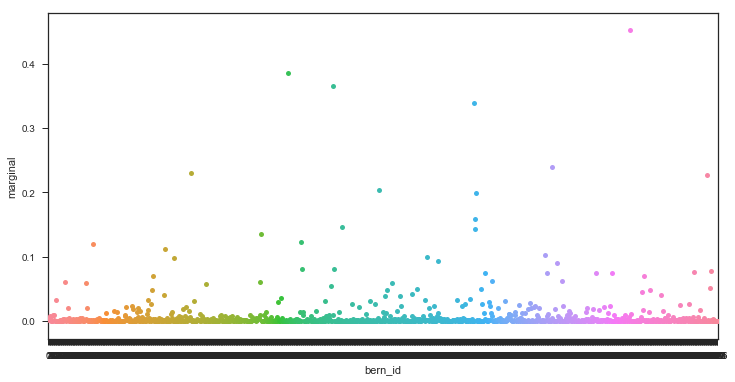

In [14]:
df = pd.DataFrame({
    'bern_id': range(num_features),
    'marginal': marginal().numpy()
})

fig, ax = plt.subplots(figsize=(12,6))
ax = sns.stripplot(x='bern_id', y='marginal', data=df, ax=ax)

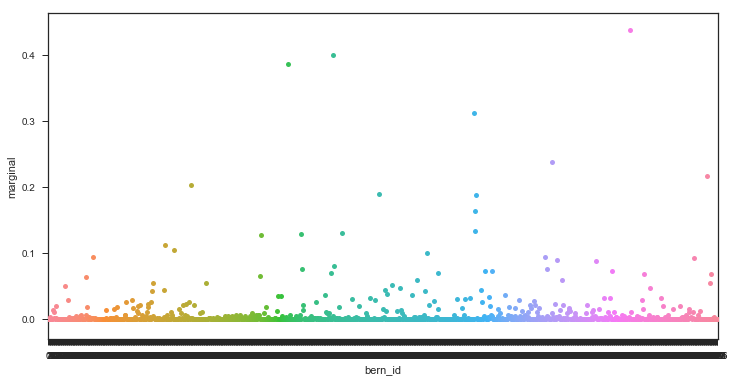

In [20]:
pi, theta = get_ml_estimate()
df_ml = pd.DataFrame({
    'bern_id': range(num_features),
    'marginal': theta[class_1.item(), :]
})

fig, ax = plt.subplots(figsize=(12,6))
ax = sns.stripplot(x='bern_id', y='marginal', data=df_ml, ax=ax)